# Предварительные действия

Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Блок кода для визуализации процесса обучения модели:

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Чтобы результаты экспериментов воспроизводились, зафиксируем seed's

In [ ]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [ ]:
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [ ]:
from torch.utils.data import random_split

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

trainset, valset, _ = random_split(dataset, lengths=[12000, 3000, 35000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch import nn


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Your code here
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        # Your code here
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

In [ ]:
batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torchmetrics
score_function = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [ ]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0
    y_true, y_pred = torch.Tensor(), torch.Tensor()

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred = model(imgs.to(device)) # Your code here
        loss = criterion(pred, labels.to(device)) # Your code here

        # Optimization
        # Nullify gradients, do a backward and do an optimization step
        # Your code here
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # End of your code

        train_loss += loss.item()

        # accumulating true labels to calculate score function
        y_true = torch.cat([y_true, labels], dim=0)

        # getting predicted labels from logits by argmax
        pred_labels = pred.detach().cpu().argmax(dim=1)
        # accumulating predicted labels to calculate score function
        y_pred = torch.cat([y_pred, pred_labels], dim=0)

    train_loss /= num_batches
    train_score = score_function(y_pred, y_true)

    return train_loss, train_score

In [ ]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0
    y_true, y_pred = torch.Tensor(), torch.Tensor()

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device)) # Your code here
            loss = criterion(pred, labels.to(device)) # Your code here

            val_loss += loss.item()

            # accumulating true labels to calculate score function
            y_true = torch.cat([y_true, labels], dim=0)

            # getting predicted labels from logits by argmax
            pred_labels = pred.detach().cpu().argmax(dim=1)
            # accumulating predicted labels to calculate score function
            y_pred = torch.cat([y_pred, pred_labels], dim=0)

    val_loss /= num_batches
    val_score = score_function(y_pred, y_true)

    return val_loss, val_score

In [ ]:
def train(model,
          train_loader,
          val_loader,
          criterion,
          optimizer,
          score_function,
          device,
          num_epochs=10):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score = train_loop(train_loader,
                                             model,
                                             criterion,
                                             optimizer,
                                             score_function,
                                             device)  # Your code here


        val_loss, val_score = val_loop(val_loader,
                                       model,
                                       criterion,
                                       score_function,
                                       device) # Your code here

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

In [ ]:
cifar10_mean = dataset.data.mean(axis=(0, 1, 2)) / 255  # Your code here
cifar10_std = dataset.data.std(axis=(0, 1, 2)) / 255  # Your code here
print(f"Mean: {cifar10_mean}, Std: {cifar10_std}")

Mean: [0.49139968 0.48215841 0.44653091], Std: [0.24703223 0.24348513 0.26158784]


Создайте трансформацию, которая включает в себя нормализацию, и подмените трансформацию в обучающем и тестовом Dataset-ах на новую.

In [ ]:
transform_with_normalize = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),  # [0..255] -> [0..1]
        torchvision.transforms.Normalize(cifar10_mean, cifar10_std),
    ]
)  # Your code here

# Your code here
dataset.transform = transform_with_normalize
testset.transform = transform_with_normalize

# Задание 3. Влияние функций активации

Исследуйте влияние функций активации на **скорость обучения (скорость снижения функции потерь) и точность предсказаний** модели.

* Используйте четыре функции активации:

 1. [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)
 2. [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU)
 3. [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
 4. Собственная реализация ReLU (реализованная методами PyTorch)

* С каждой функцией активации обучите сеть и сохраните историю изменения функции потерь и точности на обучающих данных по эпохам. Достаточно учить сеть 6–10 эпох.

* Постройте:
    1. графики функции потерь для разных функций активации в одних осях
    2. графики точности для разных функций активации в других осях (см. пример в формате результата).

Для возможности передачи в сеть желаемой функции активации, можно модифицировать конструктор класса нейросети.

Иной вариант, как изменить функцию активации: после создания экземпляра модели  можно "подменить" ей поле, отвечающее за функцию активации.

**Обратите внимание:**

* Функция `train` возвращает объект класса `ProgressPlotter`, у которого есть атрибут `.history_dict`, из которого можно по ключам `loss_train` и  `accuracy_train` извлечь историю изменения функции потерь и точности на обучающих данных по эпохам.

* При каждой функции активации нужно заново объявлять модель, оптимизатор и критерий.

**Для преподавателя:** в нашем конструкторе класса активация лежит под индексом `1` в поле `layers_stack`. Его мы и будем подменять в цикле.

In [ ]:
model = FCNet()
print(model)
print(model.layers_stack[1])

FCNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
ReLU()


Начните с самостоятельной реализации функции активации ReLU как наследника класса `nn.Module`:

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        # Your code here
        super().__init__()

    def forward(self, x):
        # Your code here
        x = torch.max(torch.tensor(0), x)  # or x[x < 0] = 0
        return x

Реализуйте эксперимент с перебором функций активации.

Рекомендуется создать список с экземплярами классов функций активации
```
activations = [nn.Sigmoid(), nn.GELU(), nn.ReLU(), CustomReLU()]
```
а затем внутри цикла по элементам списка создавать модель, передавать ей очередную функцию активации, обучать нужное число эпох и сохранять историю изменения функции потерь и точности по эпохам.

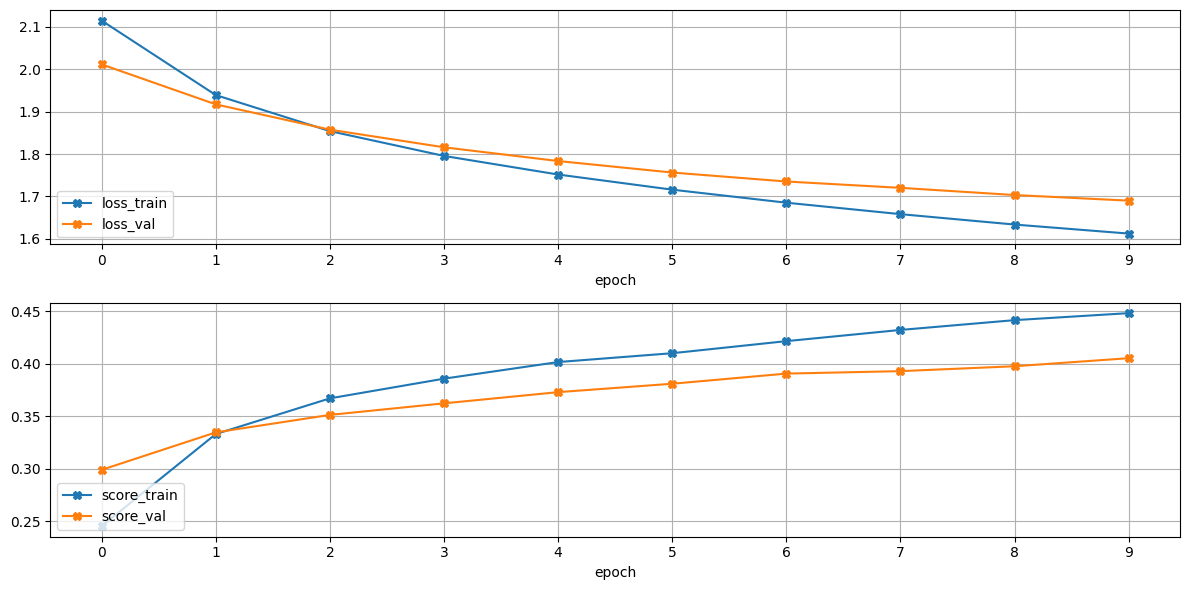

CustomReLU


In [ ]:
# Your code here
from torch import nn

# change the order so as not to give a hint in the result format
activations = [nn.ReLU(), nn.GELU(), nn.Sigmoid(), CustomReLU()]

losses = []
accuracies = []

for activation in activations:
    model = FCNet().to(device)  # Create model instance and move it to device

    model.layers_stack[1] = activation  # Change activation

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
    criterion = nn.CrossEntropyLoss()  # Loss function
    pp = train(model, train_loader, val_loader, criterion, optimizer, score_function, device, num_epochs=10)
    print(type(activation).__name__)

    losses.append(pp.history_dict["loss_train"])
    accuracies.append(pp.history_dict["score_train"])

Постройте искомые графики (пример см. в формате результата).

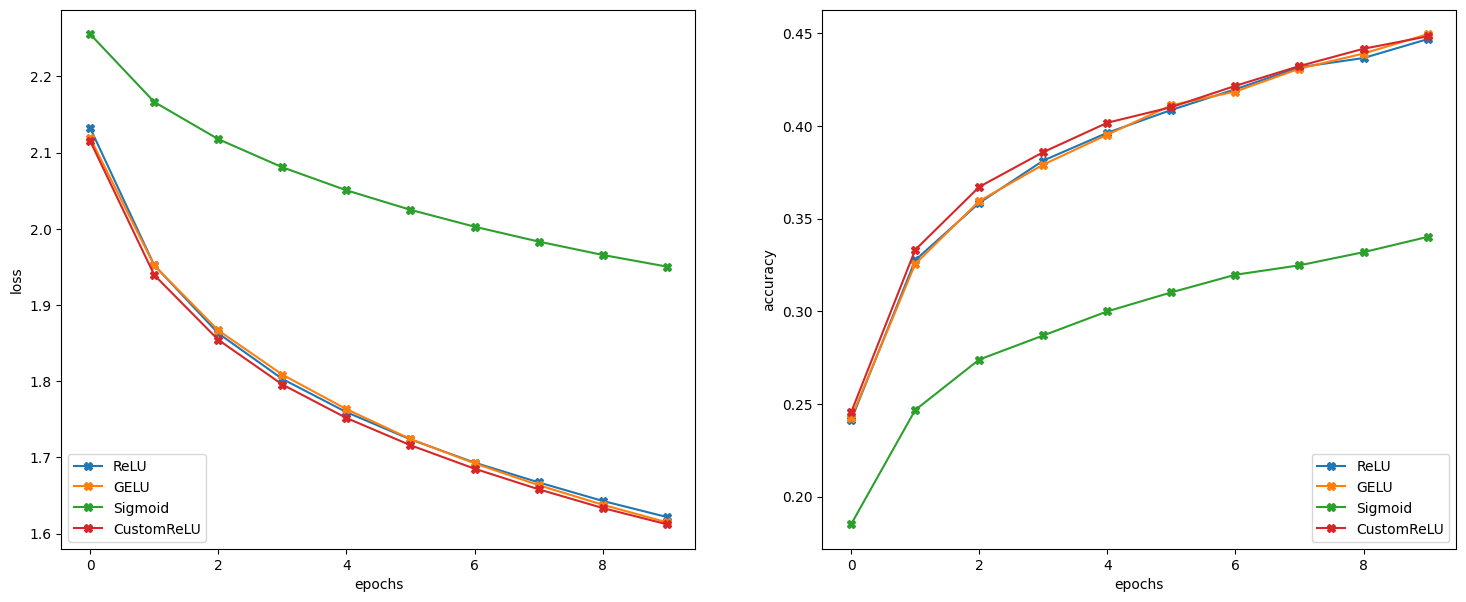

In [ ]:
# Your code here
plt.figure(figsize=(18, 7))
for i, activation in enumerate(activations):
    plt.subplot(1, 2, 1)
    plt.plot(losses[i], label=type(activation).__name__, marker="X")
    plt.grid()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(loc="lower left")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies[i], label=type(activation).__name__, marker="X")
    plt.grid()
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(loc="lower right")

plt.show()

## Формат результата

Графики функции потерь по эпохам при трех различных функциях активации, нанесенные в одних осях, и графики точности на обучающих данных по эпохам, нанесенные в других осях.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX05/result_3_task_ex05.png" width="1000">

##Памятка для преподавателя
Это задание демонстрирует студентам то, что каждое выбранное ими решение в архитектуре нейронной сети оказывает влияние на модель, и им нужно не бояться экспериментировать.

Если студент копировал код модели из лекции, то не обязательно модифицировать конструктор класса, можно просто после создания модели менять ей атрибут `.layers_stack[1]`.

Также не очевидным является то, что функция `train` возвращает объект класса `ProgressPlotter`, у которого есть `.history_dict`, из которого можно по ключам `loss_train` и `accuracy_train` достать историю изменения функции потерь и точности на обучающих данных по эпохам. Об этой функциональности нужно рассказать.

Нужно обратить внимание, что при каждой функции активации нужно заново объявлять оптимизатор и критерий.

Также это задание показывает возможность реализации своих модулей и использования их в модели. Это помогает студентам понять, что все, что "под капотом" в стандартных библиотеках машинного обучения, при необходимости можно реализовать самостоятельно.

Нужно не забывать делать `super().__init__()` при написании своих модулей.

## Идеи для самостоятельной реализации

После обучения модели в задании 4 и получения требуемого качества, можно "воспользоваться ей по назначению". Взять несколько картинок из тестовой выборки CIFAR-10, подать их в обученную модель, посмотреть на выходы, применить к ним Softmax, посмотреть на предсказываемые вероятности, посмотреть где предсказываемый класс не совпадает с истинным.

В продолжение этого, можно так обработать тестовую выборку, чтобы получить массив `y_pred`, в котором 10&nbsp;000 элементов — целых чисел — меток предсказанных классов для тестовых изображений. Также получить массив `y_true` из датасета (`testset.targets`). И воспользоваться привычными функциями для анализа качества классификации из `sklearn.metrics`:
* [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
* [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
* [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

Также можно попробовать сделать классификацию другого датасета. См. [доступные в torchvision](https://pytorch.org/vision/stable/datasets.html#image-classification). Для упражнений желательно **не**&nbsp;выбирать датасеты, с изображениями в большом разрешении (больше, чем $100\times100$).